1. Create a jupyter notebook template to do the following - for a given token and date range:
    - calculate the hourly return by timestamp
    - calculate the hourly volatility (you can use the formula we went over in class)
    - calculate maximum drawdown up to that hour for each hour
    - then plot in a 2x2 grid:
        - hourly return
        - hourly vol
        - maximum drawdown
        - close prices
        - color each day on the graph
        

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/sundaylai/opt/anaconda3/envs/lecture_4/lib/python3.9/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///data/data.db'
events_db = 'crypto_events_database'

In [3]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [4]:
prices


,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-11-11 19:00:00,64952.90,65040.28,64612.34,64771.77,498.983785,3.233695e+07,BTC,BTC
2021-11-11 20:00:00,64771.77,65265.48,64754.25,65160.00,354.873623,2.308443e+07,BTC,BTC
2021-11-11 21:00:00,65160.00,65251.76,64780.00,64826.25,401.734116,2.614084e+07,BTC,BTC


In [5]:
prices.open.rolling(3).apply(lambda x: x.mean())

ts
2021-11-05 00:00:00             NaN
2021-11-05 01:00:00             NaN
2021-11-05 02:00:00    61184.540000
2021-11-05 03:00:00    61395.296667
2021-11-05 04:00:00    61473.310000
                           ...     
2021-11-11 19:00:00    64953.860000
2021-11-11 20:00:00    64932.400000
2021-11-11 21:00:00    64961.556667
2021-11-11 22:00:00    64920.483333
2021-11-11 23:00:00    65021.246667
Name: open, Length: 168, dtype: float64

define volatility

In [6]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [7]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

column parameters:

In [8]:
prices['volatility'] = vol_ohlc(prices)
prices['hourly return']=np.log(prices.close)-np.log(prices.open)
prices['hourly drawdown'] = prices.high-prices.close

In [10]:
prices['maximum drawdown']=0
for i in range(prices.shape[0]):
     prices['maximum drawdown'].iloc[i]=prices['hourly drawdown'].iloc[0:(i+1)].max()

In [14]:
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,volatility,hourly return,hourly drawdown,maximum drawdown,max drawdown
ts,,,,,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN,0.004176,87.15,87.15,87.15
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,NaN,-0.008560,616.32,616.32,616.32
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,NaN,0.014666,19.28,616.32,616.32
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,NaN,-0.002303,281.47,616.32,616.32
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,NaN,0.009175,117.93,616.32,616.32


In [11]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

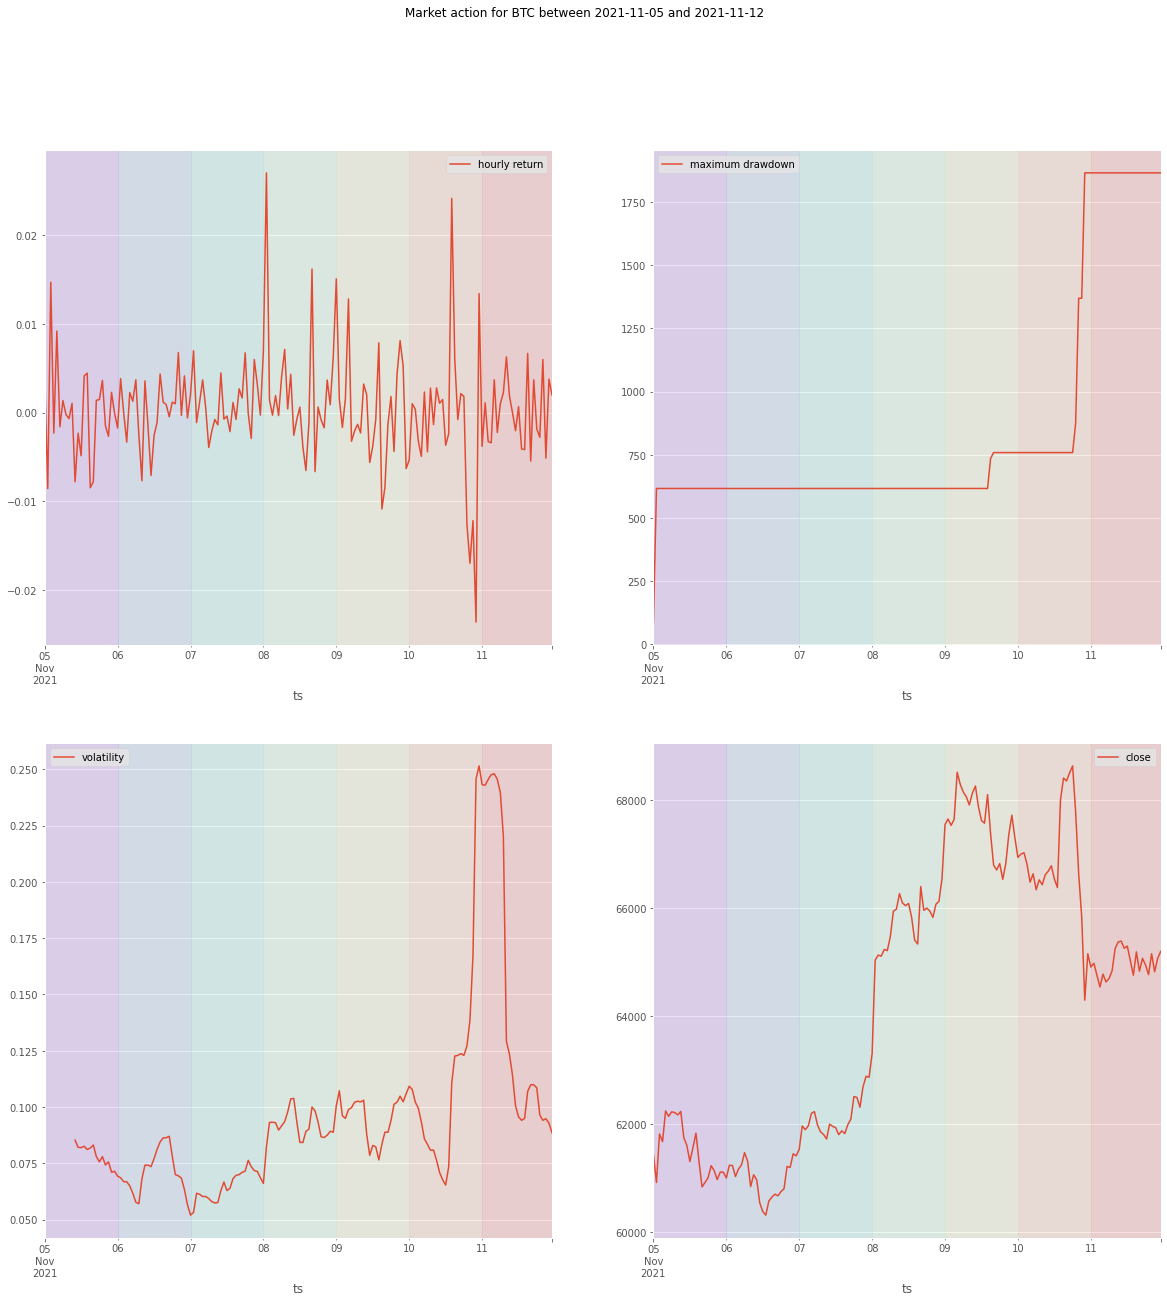

In [12]:
series_plot(prices[['hourly return']], ax=ax[0,0])
series_plot(prices[['volatility']], ax=ax[1,0])
series_plot(prices[['maximum drawdown']], ax=ax[0,1])
series_plot(prices[['close']], ax=ax[1,1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

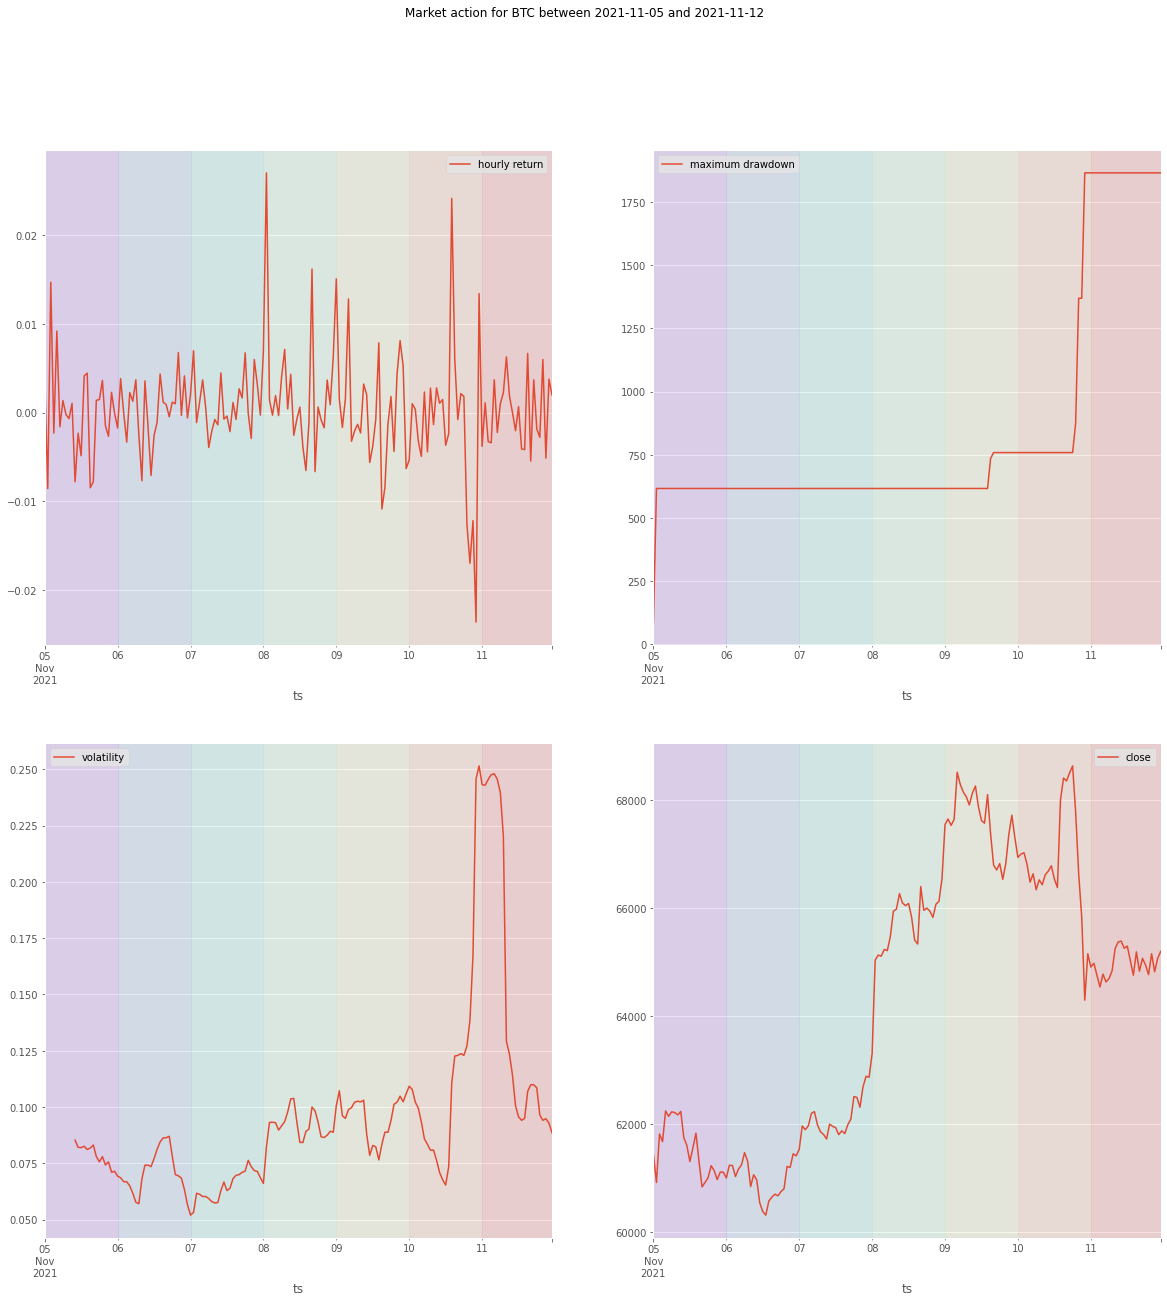

In [13]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)